In [70]:
import numpy as np
# %matplotlib ipympl
import matplotlib.pyplot as plt
import scipy

symbol_time = 0.01 # 10ms per symbol
baudrate = 1/symbol_time
samp_rate = 100_000 # Hz
SPS = int(samp_rate * symbol_time)

lowcut, highcut = 5_000, 20_000  # target band
center_freq = (highcut + lowcut) / 2
bandwidth = highcut - lowcut  # 15 kHz

WINDOW_START_SECONDS = 1.1
WINDOW_INDEX_START = int(WINDOW_START_SECONDS * samp_rate)
SYMBOLS_TO_PLOT = 40
SAMPLES_TO_PLOT = SYMBOLS_TO_PLOT * SPS # n symbols to plot * samples per symbol

# Importing the samples
signal = np.fromfile("rf-dump.complex", dtype=np.complex64)
duration = len(signal)/samp_rate
t = np.linspace(0, duration, len(signal), endpoint=False)

print(f"{len(signal)} samples")
print(f"{baudrate=:#} bps")
print(f"{SPS=:#} sps")
print(f"{duration=:#} s")

17432368 samples
baudrate=100.0 bps
SPS=1000 sps
duration=174.32368 s


In [71]:
def plot_waterfall(sig, sample_rate, filename=None):
    sig = sig[WINDOW_INDEX_START:WINDOW_INDEX_START + SAMPLES_TO_PLOT]
    # Parameters
    Nfft = 512   # The number of data points used in each block for the FFT (power of 2 is better)
    noverlap = Nfft//2 # The number of points of overlap between blocks

    # Compute spectrogram (waterfall)
    fig, ax = plt.subplots(1, figsize=(12, 6))
    Pxx, freqs, bins, im = ax.specgram(
        sig,
        Fs=sample_rate,
        NFFT=Nfft,
        noverlap=noverlap,
        cmap="viridis",
        scale="dB",
        mode="psd"
    )

    # Format plot to look like inspectrum (left-to-right, time on x, freq on y)
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Frequency [Hz]")

    plt.colorbar(im, ax=ax, label="Power [dB]")
    plt.tight_layout()

    if filename:
        plt.savefig(filename)
    plt.show()

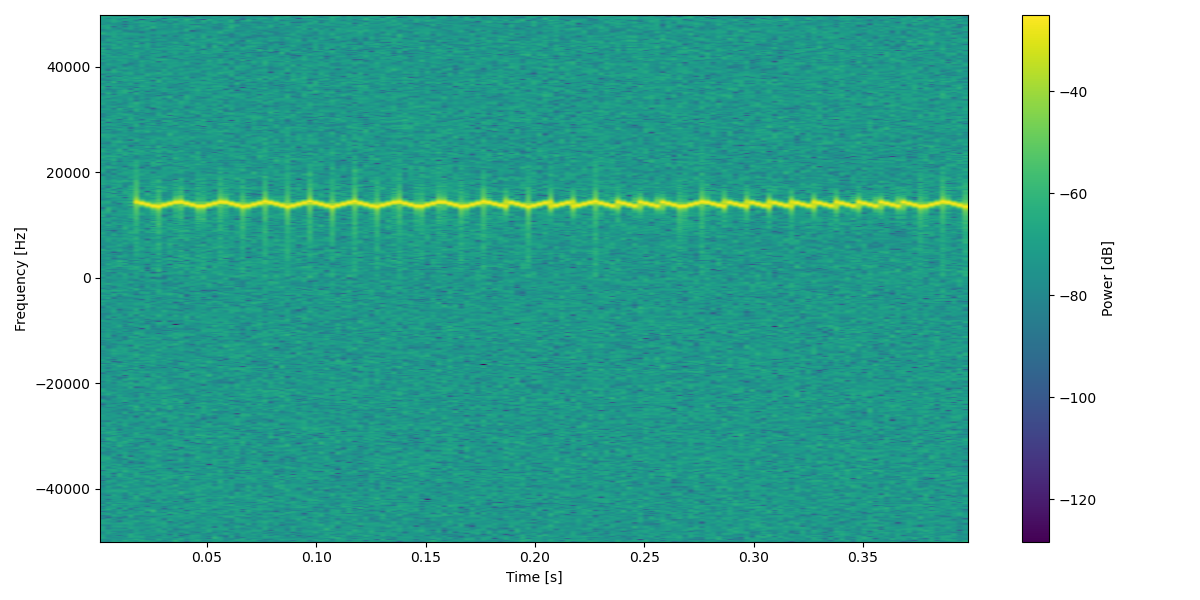

In [72]:
# Plot start of the signal
plot_waterfall(signal, samp_rate, filename="imgs/decode/01-waterfall.png")

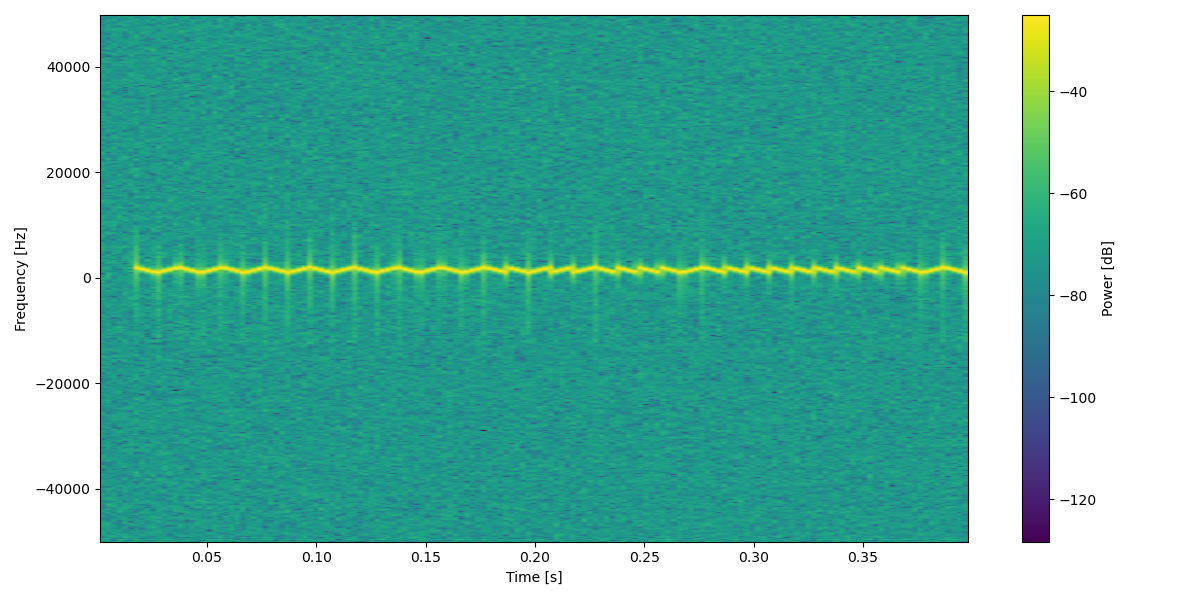

In [73]:
# Shift signal down to center it
mix = np.exp(-1j * 2 * np.pi * center_freq * t)  # complex exponential
baseband_signal = signal * mix

plot_waterfall(baseband_signal, samp_rate, filename="imgs/decode/02-centered-waterfall.png")

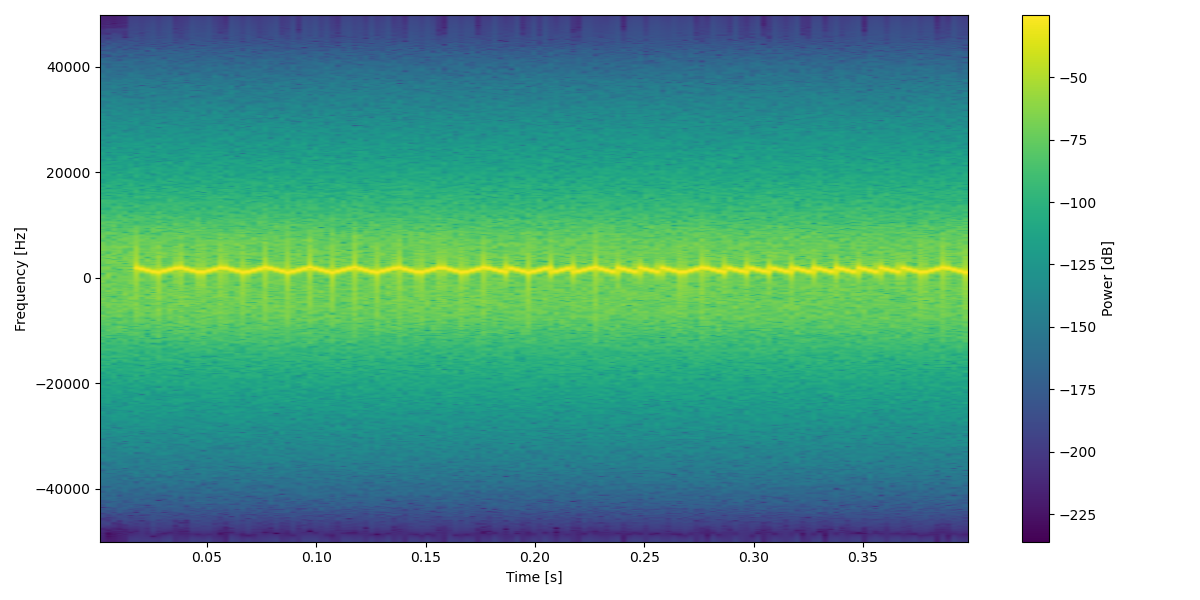

In [74]:
# Lowpass filter to keep only desired bandwidth
nyq = 0.5 * samp_rate
cutoff = bandwidth / 2 / nyq  # normalized cutoff
b, a = scipy.signal.butter(4, cutoff, btype='low')
filtered = scipy.signal.lfilter(b, a, baseband_signal)

plot_waterfall(filtered, samp_rate, filename="imgs/decode/03-filtered-waterfall.png")


In [75]:
def time_plot(sig, plot_title, xlabel, ylabel, filename=None):
    sig = sig[WINDOW_INDEX_START:WINDOW_INDEX_START + SAMPLES_TO_PLOT]
    plt.figure(figsize=(10, 4))
    plt.plot(sig)
    plt.title(plot_title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.tight_layout()
    if filename:
        plt.savefig(filename)
    plt.show()

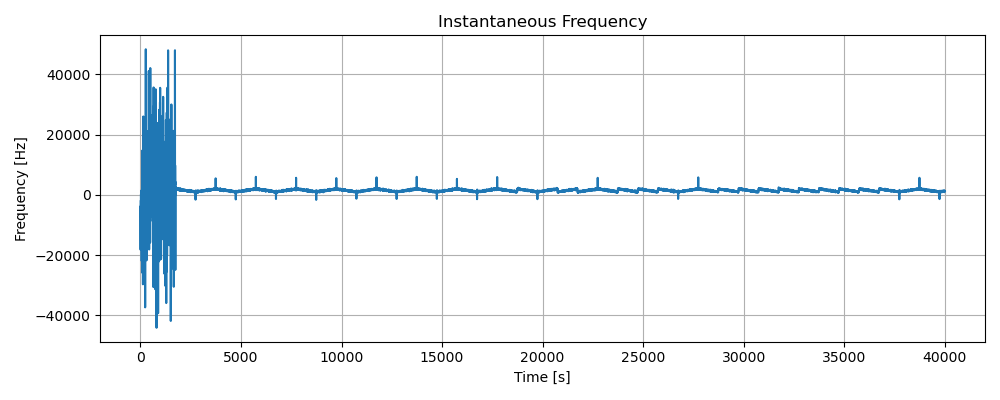

In [76]:
# Get instantaneous phase
phase = np.unwrap(np.angle(filtered))

# Get instantaneous frequency
frequency = np.diff(phase) / (2*np.pi) * samp_rate

time_plot(frequency, "Instantaneous Frequency", "Time [s]", "Frequency [Hz]", filename="imgs/decode/04-instantaneous-frequency.png")


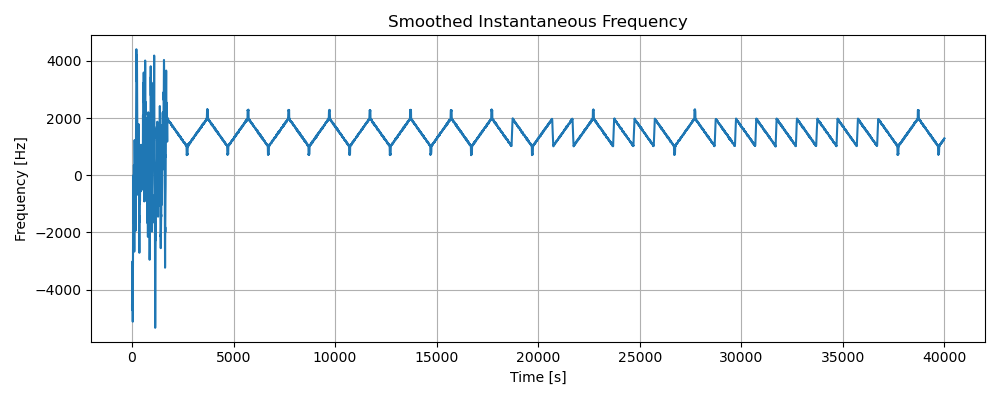

In [77]:
# Smooth out frequency plot using moving average
window_size = 50

smoothed_frequency = np.convolve(frequency, np.ones(window_size)/window_size, mode='valid')
time_plot(smoothed_frequency, "Smoothed Instantaneous Frequency", "Time [s]", "Frequency [Hz]", filename="imgs/decode/05-smoothed-instantaneous-frequency.png")

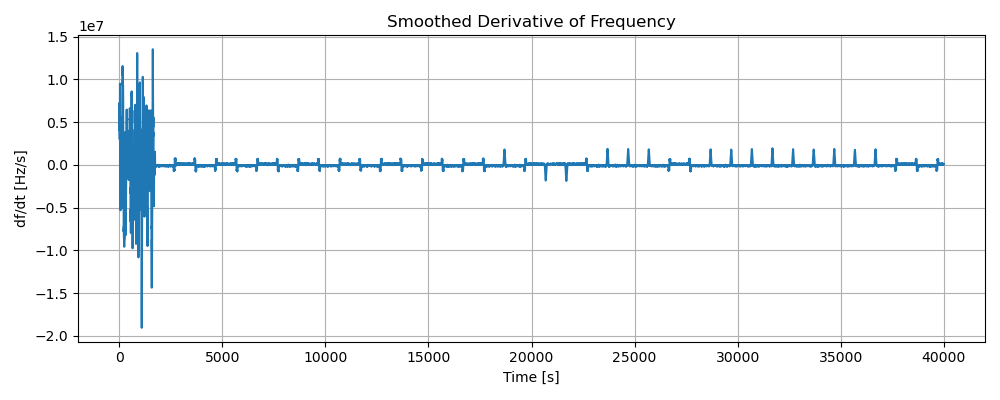

In [ ]:
# Compute derivative of the smoothed signal to get a squared signal around the x axis
squared_signal = np.diff(smoothed_frequency) * samp_rate

# Smooth the squared signal using moving average
window_size = 50
smoothed_squared_signal = np.convolve(squared_signal, np.ones(window_size)/window_size, mode='valid')

time_plot(smoothed_squared_signal, "Smoothed Derivative of Frequency", "Time [s]", "df/dt [Hz/s]", filename="imgs/decode/06-smoothed-derivative-frequency.png")

250
69729


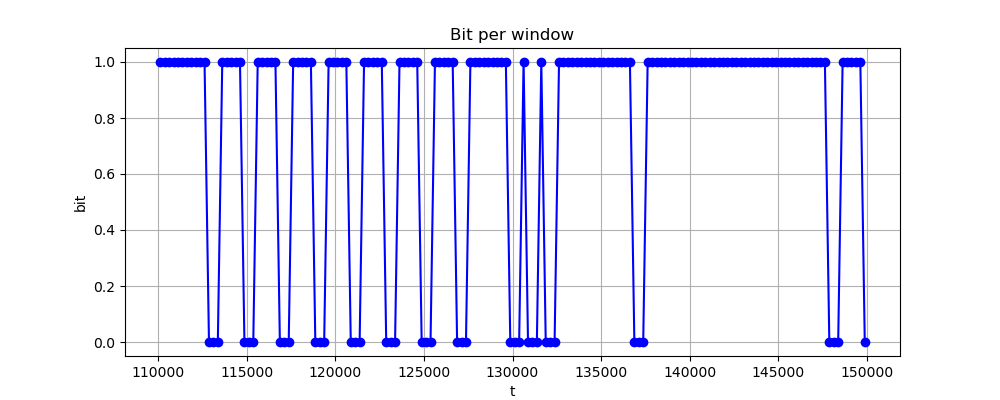

In [ ]:
# Recover bits counting how many samples are > 0 in a window of SPS/4
# this way every transmitted bit is repreented by 4 symbols
# we use 4 because it divides the value of SPS (1000) giving an integer size
# which is useful in order to not lost synchronization

signal = smoothed_squared_signal
window_size = SPS // 4

# Number of windows
num_windows = len(signal) // window_size

upsampled_bits = np.zeros(num_windows, dtype=int)
t = np.zeros(num_windows, dtype=int)

for i in range(num_windows):
    start = i * window_size
    end = start + window_size

    if (signal[start:end] > 0).sum() >= window_size*0.80:
        upsampled_bits[i] = 0  # positive -> increasing frequency -> symbol 0
    else:
        upsampled_bits[i] = 1  # negative -> decreasing frequency -> symbol 1
    
    t[i] = start + window_size//2

sig = upsampled_bits[WINDOW_INDEX_START//window_size:WINDOW_INDEX_START//window_size + SAMPLES_TO_PLOT//window_size]
t = t[WINDOW_INDEX_START//window_size:WINDOW_INDEX_START//window_size + SAMPLES_TO_PLOT//window_size]

plt.figure(figsize=(10, 4))
plt.plot(t, sig, 'bo-')
plt.title("Bit per window")
plt.xlabel("t")
plt.ylabel("bit")
plt.grid(True)
plt.savefig("imgs/decode/07-upsampled-bits.png")
plt.show()

In [80]:
def hamming74_decode_block(codeword):
    """
    Decode a single Hamming(7,4) block.
    Input: list of 7 bits.
    Returns: (data_bits, error_position)
    """
    if len(codeword) != 7:
        raise ValueError("Block must be 7 bits for Hamming(7,4)")

    # Calculate syndrome bits
    s1 = codeword[0] ^ codeword[2] ^ codeword[4] ^ codeword[6]
    s2 = codeword[1] ^ codeword[2] ^ codeword[5] ^ codeword[6]
    s3 = codeword[3] ^ codeword[4] ^ codeword[5] ^ codeword[6]
    syndrome = (s3, s2, s1)

    # Syndrome table
    syndrome_table = {
        (0,0,0): 0,
        (0,0,1): 1,
        (0,1,0): 2,
        (0,1,1): 3,
        (1,0,0): 4,
        (1,0,1): 5,
        (1,1,0): 6,
        (1,1,1): 7,
    }

    error_pos = syndrome_table.get(syndrome, 0)

    # Correct error if needed
    corrected = codeword[:]
    if error_pos != 0:
        corrected[error_pos - 1] ^= 1

    # Extract data bits (positions 3,5,6,7)
    data_bits = [corrected[2], corrected[4], corrected[5], corrected[6]]

    return data_bits, error_pos


def hamming74_decode_stream(bitstream):
    """
    Decode a bitstream consisting of concatenated Hamming(7,4) blocks.
    Returns: (decoded_bits, error_positions)
    """
    if len(bitstream) % 7 != 0:
        raise ValueError("Bitstream length must be multiple of 7")

    decoded_bits = []
    error_positions = []
    for i in range(0, len(bitstream), 7):
        block = bitstream[i:i+7]
        data, err = hamming74_decode_block(block)
        decoded_bits.extend(data)
        error_positions.append(err)
    return decoded_bits, error_positions

# Pack bits into bytes
def bits2bytes(data):
    bits = "".join(map(str, data))
    return bytes(int(bits[i:i+8], 2) for i in range(0, len(bits), 8))

In [ ]:
# Find transmission preamble
SPS = 4
PREAMBLE = ([1]*SPS + [0]*SPS) * 8
FRAME_LEN_BITS = 912

decoded_bits = upsampled_bits.tolist()

def detect_preamble(signal, preamble, threshold=0.8):
    signal = np.array(signal)
    preamble = np.array(preamble)
    L = len(preamble)

    matches = []
    for i in range(len(signal) - L + 1):
        window = signal[i:i+L]
        similarity = (window == preamble).mean()  # fraction of equal bits
        if similarity >= threshold:
            matches.append(i)

    return matches

# Given each preamble, recover the bits from the symbols
# and hamming decode.
for i in detect_preamble(decoded_bits, PREAMBLE, 0.8):
    f = decoded_bits[i:i + FRAME_LEN_BITS*SPS]

    bits = [
        1 if sum(f[i:i+SPS]) >= SPS/2 else 0
        for i in range(0, len(f), SPS)
    ]

    if len(bits) != FRAME_LEN_BITS:
        continue

    data = bits[16:]
    corrected = hamming74_decode_stream(data)[0]
    msg = bits2bytes(corrected)

    if b"space{" in msg:
        print(f"{msg}")
        

b'?\xfa\x00\x00\x07\xffSAT=NIGHTINGALE;STATUS=space{1t_w4s_i_4n_h4mming_bird?}\x00\xc4 '
b'?\xfa\x00\x00\x07\xffSAT=NIGHTINGALE;STATUS=space{1t_w4s_i_4n_h4mming_bird?}\x00\xc4 '
